In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys


import functions.parse_data as parse
import functions.handy_functions as hf
import torch.nn as nn
import torch

from multivariate_quantile_regression.network_model import QuantileNetwork

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

from tqdm import tqdm

/tmp/ipykernel_97054/822992949.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-16 11:58:51.843934: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-16 11:58:51.879261: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-16 11:58:

In [2]:
# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    # CUDA is available, so let's set default device to GPU
    torch.set_default_device(0)
    print("CUDA is available. Using GPU.")
else:
    # CUDA is not available, so let's use the CPU
    print("CUDA is not available. Using CPU.")

# Example usage:
tensor = torch.randn(3, 3)  # Create a tensor on the selected device
print("Tensor is on device:", tensor.device)


CUDA is available. Using GPU.
Tensor is on device: cuda:0


In [3]:
channel_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06','Cloud_B07',
                 'Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13']

data_water=parse.parse('cloudrm_water.dat')
data_clear=parse.parse('cloudrm_clear.dat')
data_ice=parse.parse('cloudrm_ice.dat')
data_mixed=parse.parse('cloudrm_mixed.dat')

#Concatinate all datasets
data_all=pd.concat([data_water, data_clear, data_ice, data_mixed])
data_all=data_all.drop(columns=['Surface_Desc','Cloud_B01','Clear_B01'])
df_truth=data_all.copy()

data_all=hf.add_MSI_noise(data_all,channel_labels)

Noise standard deviation for Cloud_B02: 0.00335001428051948
Noise standard deviation for Cloud_B03: 0.002912530185416667
Noise standard deviation for Cloud_B04: 0.004058081082042254
Noise standard deviation for Cloud_B05: 0.0046524891611111115
Noise standard deviation for Cloud_B06: 0.007455351321348316
Noise standard deviation for Cloud_B07: 0.008871707484285717
Noise standard deviation for Cloud_B08: 0.04489677938000001
Noise standard deviation for Cloud_B09: 0.005688141120114942
Noise standard deviation for Cloud_B10: 0.003909328971491229
Noise standard deviation for Cloud_B11: 0.0014014724139999996
Noise standard deviation for Cloud_B12: 0.005030040539999999
Noise standard deviation for Cloud_B13: 0.004041267081999999


In [4]:
##Train test validation split##
X_labels= ['Cloud_B02','Cloud_B03','Cloud_B04','Cloud_B05','Cloud_B06',
           'Cloud_B07','Cloud_B08','Cloud_B09','Cloud_B10','Cloud_B11','Cloud_B12','Cloud_B13',
           'Sat_Zenith_Angle','Sun_Zenith_Angle','Azimuth_Diff_Angle']

#Leave out 'GOT', 'Water_Vapor'
#Band 1 no go.
y_labels=['Clear_B02','Clear_B03','Clear_B04','Clear_B05','Clear_B06',
           'Clear_B07','Clear_B08','Clear_B09','Clear_B10','Clear_B11','Clear_B12','Clear_B13']

X_truth=df_truth[X_labels]

df=hf.normalise_input_df(data_all,X_labels)
df=hf.add_noise(df,X_labels,sigma=0.001)

##Split data##
X=df[X_labels]
y=df[y_labels]

X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.05)

X_test_truth=X_truth.iloc[X_test.index] #Save truth values without normalisation

In [35]:
import random

val_size=0.05
validation_indices=np.array(random.sample(range(len(X_train['Cloud_B02'])), int(len(X_train['Cloud_B02'])*val_size)))
train_indices=[i for i in range(len(X_train['Cloud_B02'])) if np.any(validation_indices==i)==False]

quantiles=np.array([0.1,0.5,0.9])
batch_size=500

In [41]:
nepochs=200

model=QuantileNetwork(quantiles=quantiles)

# Add everything but the output layer
sequence=nn.Sequential(
    nn.Linear(len(X_labels),256),
    nn.ReLU(),
    nn.Linear(256,256),
    nn.ReLU(),
    nn.Linear(256, len(quantiles)*len(y_labels)) #Output dimesion is number of quantiles times number of target variables
)
model.fit(X_train.to_numpy(),y_train.to_numpy(), 
          train_indices, 
          validation_indices, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequence)

Epoch 1


Batch number:   0%|          | 0/361 [00:00<?, ?it/s]

Batch number: 100%|██████████| 361/361 [00:01<00:00, 349.01it/s]

Training loss [0.9108045] Validation loss [0.642803]
----New best validation loss---- [0.642803]
Epoch 2



Batch number: 100%|██████████| 361/361 [00:01<00:00, 341.16it/s]

Training loss [0.59442604] Validation loss [0.5569431]
----New best validation loss---- [0.5569431]
Epoch 3



Batch number: 100%|██████████| 361/361 [00:01<00:00, 348.64it/s]

Training loss [0.5367536] Validation loss [0.5105863]
----New best validation loss---- [0.5105863]
Epoch 4



Batch number: 100%|██████████| 361/361 [00:01<00:00, 344.47it/s]

Training loss [0.50518346] Validation loss [0.49223942]
----New best validation loss---- [0.49223942]
Epoch 5



Batch number: 100%|██████████| 361/361 [00:01<00:00, 342.58it/s]

Training loss [0.48573977] Validation loss [0.4850445]
----New best validation loss---- [0.4850445]
Epoch 6



Batch number: 100%|██████████| 361/361 [00:01<00:00, 356.80it/s]

Training loss [0.46911755] Validation loss [0.46053052]
----New best validation loss---- [0.46053052]
Epoch 7



Batch number: 100%|██████████| 361/361 [00:01<00:00, 341.96it/s]

Training loss [0.45973003] Validation loss [0.45078418]
----New best validation loss---- [0.45078418]
Epoch 8



Batch number: 100%|██████████| 361/361 [00:01<00:00, 346.73it/s]

Training loss [0.4507222] Validation loss [0.44456238]
----New best validation loss---- [0.44456238]
Epoch 9



Batch number: 100%|██████████| 361/361 [00:01<00:00, 343.23it/s]

Training loss [0.44148523] Validation loss [0.4387034]
----New best validation loss---- [0.4387034]
Epoch 10



Batch number: 100%|██████████| 361/361 [00:01<00:00, 348.46it/s]

Training loss [0.43548277] Validation loss [0.4339251]
----New best validation loss---- [0.4339251]
Epoch 11



Batch number: 100%|██████████| 361/361 [00:01<00:00, 349.46it/s]


Training loss [0.4318808] Validation loss [0.42636812]
----New best validation loss---- [0.42636812]
Epoch 12


Batch number: 100%|██████████| 361/361 [00:01<00:00, 339.59it/s]

Training loss [0.42629877] Validation loss [0.4233824]
----New best validation loss---- [0.4233824]
Epoch 13



Batch number: 100%|██████████| 361/361 [00:01<00:00, 340.92it/s]

Training loss [0.42229196] Validation loss [0.42539808]
Epoch 14



Batch number: 100%|██████████| 361/361 [00:01<00:00, 342.44it/s]

Training loss [0.41891822] Validation loss [0.4146126]
----New best validation loss---- [0.4146126]
Epoch 15



Batch number: 100%|██████████| 361/361 [00:01<00:00, 358.88it/s]


Training loss [0.41557318] Validation loss [0.4137007]
----New best validation loss---- [0.4137007]
Epoch 16


Batch number: 100%|██████████| 361/361 [00:01<00:00, 339.04it/s]

Training loss [0.4122144] Validation loss [0.41153425]
----New best validation loss---- [0.41153425]
Epoch 17



Batch number: 100%|██████████| 361/361 [00:01<00:00, 346.36it/s]

Training loss [0.4111662] Validation loss [0.40817317]
----New best validation loss---- [0.40817317]
Epoch 18



Batch number: 100%|██████████| 361/361 [00:01<00:00, 343.22it/s]

Training loss [0.40692627] Validation loss [0.40716556]
----New best validation loss---- [0.40716556]
Epoch 19



Batch number: 100%|██████████| 361/361 [00:01<00:00, 340.70it/s]

Training loss [0.40521637] Validation loss [0.40207005]
----New best validation loss---- [0.40207005]
Epoch 20



Batch number: 100%|██████████| 361/361 [00:01<00:00, 352.46it/s]

Training loss [0.4025119] Validation loss [0.4005076]
----New best validation loss---- [0.4005076]
Epoch 21



Batch number: 100%|██████████| 361/361 [00:01<00:00, 357.87it/s]

Training loss [0.40146744] Validation loss [0.40807188]
Epoch 22



Batch number: 100%|██████████| 361/361 [00:01<00:00, 345.10it/s]

Training loss [0.3975662] Validation loss [0.4009194]
Epoch 23



Batch number: 100%|██████████| 361/361 [00:01<00:00, 345.63it/s]

Training loss [0.3957784] Validation loss [0.3932154]
----New best validation loss---- [0.3932154]
Epoch 24



Batch number: 100%|██████████| 361/361 [00:01<00:00, 340.93it/s]

Training loss [0.3944843] Validation loss [0.3897064]
----New best validation loss---- [0.3897064]
Epoch 25



Batch number: 100%|██████████| 361/361 [00:01<00:00, 351.24it/s]

Training loss [0.39328635] Validation loss [0.3902726]
Epoch 26



Batch number: 100%|██████████| 361/361 [00:00<00:00, 363.18it/s]

Training loss [0.39100024] Validation loss [0.3896013]
----New best validation loss---- [0.3896013]
Epoch 27



Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.30it/s]


Training loss [0.389256] Validation loss [0.38680336]
----New best validation loss---- [0.38680336]
Epoch 28


Batch number: 100%|██████████| 361/361 [00:00<00:00, 515.55it/s]


Training loss [0.38888913] Validation loss [0.38871762]
Epoch 29


Batch number: 100%|██████████| 361/361 [00:00<00:00, 514.44it/s]


Training loss [0.3864893] Validation loss [0.3869471]
Epoch 30


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.41it/s]


Training loss [0.38457704] Validation loss [0.38527268]
----New best validation loss---- [0.38527268]
Epoch 31


Batch number: 100%|██████████| 361/361 [00:00<00:00, 515.19it/s]


Training loss [0.38473752] Validation loss [0.38028878]
----New best validation loss---- [0.38028878]
Epoch 32


Batch number: 100%|██████████| 361/361 [00:00<00:00, 514.63it/s]


Training loss [0.3830132] Validation loss [0.38830516]
Epoch 33


Batch number: 100%|██████████| 361/361 [00:00<00:00, 512.78it/s]


Training loss [0.3818211] Validation loss [0.38280088]
Epoch 34


Batch number: 100%|██████████| 361/361 [00:00<00:00, 462.86it/s]

Training loss [0.3793163] Validation loss [0.3778727]
----New best validation loss---- [0.3778727]
Epoch 35



Batch number: 100%|██████████| 361/361 [00:01<00:00, 335.84it/s]

Training loss [0.37904337] Validation loss [0.38045344]
Epoch 36



Batch number: 100%|██████████| 361/361 [00:01<00:00, 334.07it/s]

Training loss [0.37781385] Validation loss [0.38313714]
Epoch 37



Batch number: 100%|██████████| 361/361 [00:00<00:00, 499.08it/s]

Training loss [0.3761897] Validation loss [0.37926596]
Epoch 38



Batch number: 100%|██████████| 361/361 [00:00<00:00, 505.01it/s]

Training loss [0.37582555] Validation loss [0.38897625]
Epoch 39



Batch number: 100%|██████████| 361/361 [00:00<00:00, 506.85it/s]

Training loss [0.37443873] Validation loss [0.3780106]
Epoch 40



Batch number: 100%|██████████| 361/361 [00:01<00:00, 349.84it/s]

Training loss [0.37266684] Validation loss [0.37046698]
----New best validation loss---- [0.37046698]
Epoch 41



Batch number: 100%|██████████| 361/361 [00:01<00:00, 336.68it/s]

Training loss [0.37187985] Validation loss [0.37607455]
Epoch 42



Batch number: 100%|██████████| 361/361 [00:01<00:00, 335.34it/s]

Training loss [0.37184474] Validation loss [0.37229165]
Epoch 43



Batch number: 100%|██████████| 361/361 [00:01<00:00, 345.26it/s]

Training loss [0.3715156] Validation loss [0.37017205]
----New best validation loss---- [0.37017205]
Epoch 44



Batch number: 100%|██████████| 361/361 [00:01<00:00, 332.33it/s]

Training loss [0.369885] Validation loss [0.3717703]
Epoch 45



Batch number: 100%|██████████| 361/361 [00:01<00:00, 335.10it/s]

Training loss [0.36875293] Validation loss [0.37351367]
Epoch 46



Batch number: 100%|██████████| 361/361 [00:01<00:00, 335.07it/s]

Training loss [0.3674136] Validation loss [0.37061116]
Epoch 47



Batch number: 100%|██████████| 361/361 [00:01<00:00, 337.60it/s]

Training loss [0.36796892] Validation loss [0.3716125]
Epoch 48



Batch number: 100%|██████████| 361/361 [00:01<00:00, 350.14it/s]

Training loss [0.36662343] Validation loss [0.36865652]
----New best validation loss---- [0.36865652]
Epoch 49



Batch number: 100%|██████████| 361/361 [00:00<00:00, 501.48it/s]

Training loss [0.3648955] Validation loss [0.36955202]
Epoch 50



Batch number: 100%|██████████| 361/361 [00:00<00:00, 499.63it/s]

Training loss [0.36527756] Validation loss [0.36596]
----New best validation loss---- [0.36596]
Epoch 51



Batch number: 100%|██████████| 361/361 [00:00<00:00, 502.07it/s]

Training loss [0.3637471] Validation loss [0.36786744]
Epoch 52



Batch number: 100%|██████████| 361/361 [00:00<00:00, 503.26it/s]

Training loss [0.36296546] Validation loss [0.3661529]
Epoch 53



Batch number: 100%|██████████| 361/361 [00:00<00:00, 499.30it/s]

Training loss [0.36306897] Validation loss [0.3685221]
Epoch 54



Batch number: 100%|██████████| 361/361 [00:00<00:00, 500.36it/s]

Training loss [0.36191446] Validation loss [0.3663169]
Epoch 55



Batch number: 100%|██████████| 361/361 [00:00<00:00, 497.19it/s]

Training loss [0.36111513] Validation loss [0.36356977]
----New best validation loss---- [0.36356977]
Epoch 56



Batch number: 100%|██████████| 361/361 [00:00<00:00, 502.70it/s]

Training loss [0.36043578] Validation loss [0.35818136]
----New best validation loss---- [0.35818136]
Epoch 57



Batch number: 100%|██████████| 361/361 [00:00<00:00, 499.60it/s]

Training loss [0.35954404] Validation loss [0.359798]
Epoch 58



Batch number: 100%|██████████| 361/361 [00:00<00:00, 500.48it/s]

Training loss [0.35982886] Validation loss [0.35974824]
Epoch 59



Batch number: 100%|██████████| 361/361 [00:00<00:00, 500.08it/s]

Training loss [0.3584755] Validation loss [0.3635067]
Epoch 60



Batch number: 100%|██████████| 361/361 [00:00<00:00, 500.21it/s]

Training loss [0.35848466] Validation loss [0.3568184]
----New best validation loss---- [0.3568184]
Epoch 61



Batch number: 100%|██████████| 361/361 [00:00<00:00, 500.76it/s]

Training loss [0.357648] Validation loss [0.36201045]
Epoch 62



Batch number: 100%|██████████| 361/361 [00:00<00:00, 499.30it/s]

Training loss [0.35664636] Validation loss [0.36164883]
Epoch 63



Batch number: 100%|██████████| 361/361 [00:00<00:00, 500.40it/s]

Training loss [0.35857043] Validation loss [0.35773644]
Epoch 64



Batch number: 100%|██████████| 361/361 [00:00<00:00, 513.85it/s]


Training loss [0.35512102] Validation loss [0.36032528]
Epoch 65


Batch number: 100%|██████████| 361/361 [00:00<00:00, 502.80it/s]

Training loss [0.3551642] Validation loss [0.3566656]
----New best validation loss---- [0.3566656]
Epoch 66



Batch number: 100%|██████████| 361/361 [00:00<00:00, 500.86it/s]

Training loss [0.35506648] Validation loss [0.3602398]
Epoch 67



Batch number: 100%|██████████| 361/361 [00:00<00:00, 501.97it/s]

Training loss [0.35473695] Validation loss [0.35554]
----New best validation loss---- [0.35554]
Epoch 68



Batch number: 100%|██████████| 361/361 [00:00<00:00, 502.97it/s]

Training loss [0.35403144] Validation loss [0.35614616]
Epoch 69



Batch number: 100%|██████████| 361/361 [00:00<00:00, 502.05it/s]

Training loss [0.3540003] Validation loss [0.3544409]
----New best validation loss---- [0.3544409]
Epoch 70



Batch number: 100%|██████████| 361/361 [00:00<00:00, 502.29it/s]

Training loss [0.35307854] Validation loss [0.35680807]
Epoch 71



Batch number: 100%|██████████| 361/361 [00:00<00:00, 504.03it/s]

Training loss [0.3526993] Validation loss [0.352124]
----New best validation loss---- [0.352124]
Epoch 72



Batch number: 100%|██████████| 361/361 [00:00<00:00, 500.24it/s]

Training loss [0.35159105] Validation loss [0.3590208]
Epoch 73



Batch number: 100%|██████████| 361/361 [00:00<00:00, 501.51it/s]

Training loss [0.35148713] Validation loss [0.36213037]
Epoch 74



Batch number: 100%|██████████| 361/361 [00:00<00:00, 502.08it/s]

Training loss [0.35138556] Validation loss [0.35778627]
Epoch 75



Batch number: 100%|██████████| 361/361 [00:00<00:00, 498.77it/s]

Training loss [0.35013816] Validation loss [0.35230678]
Epoch 76



Batch number: 100%|██████████| 361/361 [00:00<00:00, 501.78it/s]

Training loss [0.35051864] Validation loss [0.36197737]
Epoch 77



Batch number: 100%|██████████| 361/361 [00:00<00:00, 501.61it/s]

Training loss [0.34978426] Validation loss [0.35166726]
----New best validation loss---- [0.35166726]
Epoch 78



Batch number: 100%|██████████| 361/361 [00:00<00:00, 502.16it/s]

Training loss [0.35044983] Validation loss [0.34921086]
----New best validation loss---- [0.34921086]
Epoch 79



Batch number: 100%|██████████| 361/361 [00:00<00:00, 502.99it/s]

Training loss [0.3491603] Validation loss [0.35416493]
Epoch 80



Batch number: 100%|██████████| 361/361 [00:00<00:00, 502.50it/s]

Training loss [0.34860405] Validation loss [0.3494674]
Epoch 81



Batch number: 100%|██████████| 361/361 [00:00<00:00, 501.17it/s]

Training loss [0.34837112] Validation loss [0.35012892]
Epoch 82



Batch number: 100%|██████████| 361/361 [00:00<00:00, 500.24it/s]

Training loss [0.3470432] Validation loss [0.34787673]
----New best validation loss---- [0.34787673]
Epoch 83



Batch number: 100%|██████████| 361/361 [00:00<00:00, 513.70it/s]


Training loss [0.347733] Validation loss [0.35062885]
Epoch 84


Batch number: 100%|██████████| 361/361 [00:00<00:00, 512.24it/s]


Training loss [0.34671184] Validation loss [0.3490059]
Epoch 85


Batch number: 100%|██████████| 361/361 [00:00<00:00, 512.25it/s]

Training loss [0.34608364] Validation loss [0.34729058]
----New best validation loss---- [0.34729058]
Epoch 86



Batch number: 100%|██████████| 361/361 [00:00<00:00, 513.48it/s]


Training loss [0.34542754] Validation loss [0.3467348]
----New best validation loss---- [0.3467348]
Epoch 87


Batch number: 100%|██████████| 361/361 [00:00<00:00, 512.76it/s]

Training loss [0.34599078] Validation loss [0.34843078]
Epoch 88



Batch number: 100%|██████████| 361/361 [00:00<00:00, 512.13it/s]


Training loss [0.3446575] Validation loss [0.34805593]
Epoch 89


Batch number: 100%|██████████| 361/361 [00:00<00:00, 510.92it/s]


Training loss [0.34474647] Validation loss [0.34987757]
Epoch 90


Batch number: 100%|██████████| 361/361 [00:00<00:00, 510.32it/s]

Training loss [0.34482792] Validation loss [0.34522298]
----New best validation loss---- [0.34522298]
Epoch 91



Batch number: 100%|██████████| 361/361 [00:00<00:00, 510.23it/s]

Training loss [0.34385356] Validation loss [0.3479274]
Epoch 92



Batch number: 100%|██████████| 361/361 [00:00<00:00, 509.67it/s]

Training loss [0.34392187] Validation loss [0.35168308]
Epoch 93



Batch number: 100%|██████████| 361/361 [00:00<00:00, 510.72it/s]

Training loss [0.34326118] Validation loss [0.34730104]
Epoch 94



Batch number: 100%|██████████| 361/361 [00:00<00:00, 448.80it/s]

Training loss [0.34270456] Validation loss [0.34451544]
----New best validation loss---- [0.34451544]
Epoch 95



Batch number: 100%|██████████| 361/361 [00:00<00:00, 515.06it/s]


Training loss [0.34281412] Validation loss [0.34444097]
----New best validation loss---- [0.34444097]
Epoch 96


Batch number: 100%|██████████| 361/361 [00:00<00:00, 515.63it/s]


Training loss [0.3423353] Validation loss [0.34321]
----New best validation loss---- [0.34321]
Epoch 97


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.92it/s]


Training loss [0.3420836] Validation loss [0.34463918]
Epoch 98


Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.17it/s]


Training loss [0.34151366] Validation loss [0.3465953]
Epoch 99


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.89it/s]


Training loss [0.3409431] Validation loss [0.34116104]
----New best validation loss---- [0.34116104]
Epoch 100


Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.87it/s]


Training loss [0.34014505] Validation loss [0.3416121]
Epoch 101


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.86it/s]


Training loss [0.33966514] Validation loss [0.34353074]
Epoch 102


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.45it/s]


Training loss [0.3410533] Validation loss [0.34276956]
Epoch 103


Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.28it/s]


Training loss [0.339811] Validation loss [0.3456567]
Epoch 104


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.54it/s]


Training loss [0.33953476] Validation loss [0.34445703]
Epoch 105


Batch number: 100%|██████████| 361/361 [00:00<00:00, 529.57it/s]

Training loss [0.33968887] Validation loss [0.34490874]
Epoch 106



Batch number: 100%|██████████| 361/361 [00:00<00:00, 532.78it/s]

Training loss [0.33871073] Validation loss [0.34497073]
Epoch 107



Batch number: 100%|██████████| 361/361 [00:00<00:00, 512.68it/s]

Training loss [0.3396325] Validation loss [0.34128186]
Epoch 108



Batch number: 100%|██████████| 361/361 [00:00<00:00, 513.22it/s]


Training loss [0.33890146] Validation loss [0.34446707]
Epoch 109


Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.89it/s]


Training loss [0.33843488] Validation loss [0.34088278]
----New best validation loss---- [0.34088278]
Epoch 110


Batch number: 100%|██████████| 361/361 [00:00<00:00, 518.36it/s]


Training loss [0.33800113] Validation loss [0.34336156]
Epoch 111


Batch number: 100%|██████████| 361/361 [00:00<00:00, 518.41it/s]


Training loss [0.33758914] Validation loss [0.33696517]
----New best validation loss---- [0.33696517]
Epoch 112


Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.49it/s]


Training loss [0.33743978] Validation loss [0.3436259]
Epoch 113


Batch number: 100%|██████████| 361/361 [00:00<00:00, 518.38it/s]


Training loss [0.3370017] Validation loss [0.34069994]
Epoch 114


Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.27it/s]


Training loss [0.33712023] Validation loss [0.3442006]
Epoch 115


Batch number: 100%|██████████| 361/361 [00:00<00:00, 518.38it/s]


Training loss [0.33671108] Validation loss [0.34133086]
Epoch 116


Batch number: 100%|██████████| 361/361 [00:00<00:00, 518.82it/s]


Training loss [0.33600524] Validation loss [0.3431083]
Epoch 117


Batch number: 100%|██████████| 361/361 [00:00<00:00, 518.53it/s]


Training loss [0.33607322] Validation loss [0.33911806]
Epoch 118


Batch number: 100%|██████████| 361/361 [00:00<00:00, 518.35it/s]


Training loss [0.33563665] Validation loss [0.34047663]
Epoch 119


Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.94it/s]


Training loss [0.33532083] Validation loss [0.34017664]
Epoch 120


Batch number: 100%|██████████| 361/361 [00:00<00:00, 518.00it/s]


Training loss [0.33518177] Validation loss [0.34040412]
Epoch 121


Batch number: 100%|██████████| 361/361 [00:00<00:00, 518.40it/s]


Training loss [0.33538586] Validation loss [0.34009248]
Epoch 122


Batch number: 100%|██████████| 361/361 [00:00<00:00, 514.54it/s]


Training loss [0.33502904] Validation loss [0.3413915]
Epoch 123


Batch number: 100%|██████████| 361/361 [00:00<00:00, 513.42it/s]


Training loss [0.33520794] Validation loss [0.33623812]
----New best validation loss---- [0.33623812]
Epoch 124


Batch number: 100%|██████████| 361/361 [00:00<00:00, 512.54it/s]


Training loss [0.33406365] Validation loss [0.33911544]
Epoch 125


Batch number: 100%|██████████| 361/361 [00:00<00:00, 512.49it/s]


Training loss [0.33374557] Validation loss [0.3359214]
----New best validation loss---- [0.3359214]
Epoch 126


Batch number: 100%|██████████| 361/361 [00:00<00:00, 513.31it/s]


Training loss [0.33318594] Validation loss [0.33933553]
Epoch 127


Batch number: 100%|██████████| 361/361 [00:00<00:00, 513.64it/s]


Training loss [0.33387747] Validation loss [0.34073642]
Epoch 128


Batch number: 100%|██████████| 361/361 [00:00<00:00, 514.29it/s]


Training loss [0.33357334] Validation loss [0.3358096]
----New best validation loss---- [0.3358096]
Epoch 129


Batch number: 100%|██████████| 361/361 [00:00<00:00, 513.13it/s]


Training loss [0.33336] Validation loss [0.33649158]
Epoch 130


Batch number: 100%|██████████| 361/361 [00:00<00:00, 512.22it/s]


Training loss [0.33352855] Validation loss [0.33786792]
Epoch 131


Batch number: 100%|██████████| 361/361 [00:00<00:00, 512.36it/s]


Training loss [0.33261207] Validation loss [0.33581334]
Epoch 132


Batch number: 100%|██████████| 361/361 [00:00<00:00, 512.90it/s]


Training loss [0.33251587] Validation loss [0.33612937]
Epoch 133


Batch number: 100%|██████████| 361/361 [00:00<00:00, 512.32it/s]


Training loss [0.3321114] Validation loss [0.33704925]
Epoch 134


Batch number: 100%|██████████| 361/361 [00:00<00:00, 512.77it/s]


Training loss [0.33194035] Validation loss [0.3374571]
Epoch 135


Batch number: 100%|██████████| 361/361 [00:00<00:00, 579.49it/s]

Training loss [0.33197254] Validation loss [0.33550745]
----New best validation loss---- [0.33550745]
Epoch 136



Batch number: 100%|██████████| 361/361 [00:00<00:00, 546.54it/s]

Training loss [0.3322687] Validation loss [0.34094828]
Epoch 137



Batch number: 100%|██████████| 361/361 [00:00<00:00, 508.15it/s]

Training loss [0.33144766] Validation loss [0.336717]
Epoch 138



Batch number: 100%|██████████| 361/361 [00:00<00:00, 509.21it/s]

Training loss [0.33181477] Validation loss [0.33667007]
Epoch 139



Batch number: 100%|██████████| 361/361 [00:00<00:00, 507.71it/s]

Training loss [0.33177805] Validation loss [0.33575174]
Epoch 140



Batch number: 100%|██████████| 361/361 [00:00<00:00, 507.76it/s]

Training loss [0.33126336] Validation loss [0.3401979]
Epoch 141



Batch number: 100%|██████████| 361/361 [00:00<00:00, 509.36it/s]

Training loss [0.33074135] Validation loss [0.3342661]
----New best validation loss---- [0.3342661]
Epoch 142



Batch number: 100%|██████████| 361/361 [00:00<00:00, 509.05it/s]

Training loss [0.3304235] Validation loss [0.33531597]
Epoch 143



Batch number: 100%|██████████| 361/361 [00:00<00:00, 507.96it/s]

Training loss [0.3309424] Validation loss [0.33294076]
----New best validation loss---- [0.33294076]
Epoch 144



Batch number: 100%|██████████| 361/361 [00:00<00:00, 509.13it/s]

Training loss [0.32987365] Validation loss [0.33237657]
----New best validation loss---- [0.33237657]
Epoch 145



Batch number: 100%|██████████| 361/361 [00:00<00:00, 511.21it/s]

Training loss [0.33049992] Validation loss [0.34275484]
Epoch 146



Batch number: 100%|██████████| 361/361 [00:00<00:00, 509.72it/s]

Training loss [0.32927954] Validation loss [0.33949843]
Epoch 147



Batch number: 100%|██████████| 361/361 [00:00<00:00, 526.25it/s]

Training loss [0.3293659] Validation loss [0.33469704]
Epoch 148



Batch number: 100%|██████████| 361/361 [00:00<00:00, 508.87it/s]

Training loss [0.330147] Validation loss [0.3365374]
Epoch 149



Batch number: 100%|██████████| 361/361 [00:00<00:00, 508.87it/s]

Training loss [0.33014736] Validation loss [0.33541045]
Epoch 150



Batch number: 100%|██████████| 361/361 [00:00<00:00, 509.59it/s]

Training loss [0.329615] Validation loss [0.33484975]
Epoch 151



Batch number: 100%|██████████| 361/361 [00:00<00:00, 509.44it/s]

Training loss [0.32908556] Validation loss [0.33455104]
Epoch 152



Batch number: 100%|██████████| 361/361 [00:00<00:00, 508.59it/s]

Training loss [0.32879683] Validation loss [0.33569375]
Epoch 153



Batch number: 100%|██████████| 361/361 [00:00<00:00, 507.15it/s]

Training loss [0.3287374] Validation loss [0.33715585]
Epoch 154



Batch number: 100%|██████████| 361/361 [00:00<00:00, 510.79it/s]

Training loss [0.32827887] Validation loss [0.33286357]
Epoch 155



Batch number: 100%|██████████| 361/361 [00:00<00:00, 507.00it/s]

Training loss [0.3281842] Validation loss [0.33505076]
Epoch 156



Batch number: 100%|██████████| 361/361 [00:00<00:00, 531.05it/s]

Training loss [0.3284233] Validation loss [0.33209983]
----New best validation loss---- [0.33209983]
Epoch 157



Batch number: 100%|██████████| 361/361 [00:00<00:00, 515.86it/s]


Training loss [0.32800457] Validation loss [0.33511072]
Epoch 158


Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.68it/s]


Training loss [0.32814565] Validation loss [0.33663076]
Epoch 159


Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.02it/s]


Training loss [0.32813796] Validation loss [0.33453602]
Epoch 160


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.74it/s]


Training loss [0.32841942] Validation loss [0.3330485]
Epoch 161


Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.31it/s]


Training loss [0.32727158] Validation loss [0.3332718]
Epoch 162


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.22it/s]


Training loss [0.32736552] Validation loss [0.33399722]
Epoch 163


Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.07it/s]


Training loss [0.32718796] Validation loss [0.33651736]
Epoch 164


Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.24it/s]


Training loss [0.32696113] Validation loss [0.3329553]
Epoch 165


Batch number: 100%|██████████| 361/361 [00:00<00:00, 515.19it/s]


Training loss [0.32720044] Validation loss [0.33421525]
Epoch 166


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.34it/s]


Training loss [0.32675] Validation loss [0.33288363]
Epoch 167


Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.14it/s]


Training loss [0.32723716] Validation loss [0.32966828]
----New best validation loss---- [0.32966828]
Epoch 168


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.85it/s]


Training loss [0.32610685] Validation loss [0.33216494]
Epoch 169


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.49it/s]


Training loss [0.32631642] Validation loss [0.33277762]
Epoch 170


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.93it/s]


Training loss [0.32622325] Validation loss [0.33494022]
Epoch 171


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.30it/s]


Training loss [0.3265396] Validation loss [0.3332169]
Epoch 172


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.16it/s]


Training loss [0.32567218] Validation loss [0.33238068]
Epoch 173


Batch number: 100%|██████████| 361/361 [00:00<00:00, 518.42it/s]


Training loss [0.3253344] Validation loss [0.33092767]
Epoch 174


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.86it/s]


Training loss [0.3256458] Validation loss [0.33190086]
Epoch 175


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.15it/s]


Training loss [0.32526708] Validation loss [0.33898208]
Epoch 176


Batch number: 100%|██████████| 361/361 [00:00<00:00, 515.54it/s]


Training loss [0.32542378] Validation loss [0.3362758]
Epoch 177


Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.31it/s]


Training loss [0.32490006] Validation loss [0.33187371]
Epoch 178


Batch number: 100%|██████████| 361/361 [00:00<00:00, 518.08it/s]


Training loss [0.32537884] Validation loss [0.33018097]
Epoch 179


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.97it/s]


Training loss [0.32465807] Validation loss [0.33343697]
Epoch 180


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.23it/s]


Training loss [0.3246457] Validation loss [0.33012578]
Epoch 181


Batch number: 100%|██████████| 361/361 [00:00<00:00, 515.54it/s]


Training loss [0.32486477] Validation loss [0.33259165]
Epoch 182


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.06it/s]


Training loss [0.32456717] Validation loss [0.3319263]
Epoch 183


Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.07it/s]


Training loss [0.32437754] Validation loss [0.3288735]
----New best validation loss---- [0.3288735]
Epoch 184


Batch number: 100%|██████████| 361/361 [00:00<00:00, 518.84it/s]


Training loss [0.3242986] Validation loss [0.33078447]
Epoch 185


Batch number: 100%|██████████| 361/361 [00:00<00:00, 515.58it/s]


Training loss [0.32411948] Validation loss [0.3306202]
Epoch 186


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.51it/s]


Training loss [0.3246053] Validation loss [0.33214483]
Epoch 187


Batch number: 100%|██████████| 361/361 [00:00<00:00, 515.86it/s]


Training loss [0.3235358] Validation loss [0.33032408]
Epoch 188


Batch number: 100%|██████████| 361/361 [00:00<00:00, 515.42it/s]


Training loss [0.32368106] Validation loss [0.32796377]
----New best validation loss---- [0.32796377]
Epoch 189


Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.24it/s]


Training loss [0.32378814] Validation loss [0.32724932]
----New best validation loss---- [0.32724932]
Epoch 190


Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.75it/s]


Training loss [0.3233296] Validation loss [0.33309472]
Epoch 191


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.67it/s]


Training loss [0.32404035] Validation loss [0.33076873]
Epoch 192


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.64it/s]


Training loss [0.32330385] Validation loss [0.332075]
Epoch 193


Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.78it/s]


Training loss [0.3240144] Validation loss [0.32898274]
Epoch 194


Batch number: 100%|██████████| 361/361 [00:00<00:00, 515.89it/s]


Training loss [0.32245117] Validation loss [0.33348617]
Epoch 195


Batch number: 100%|██████████| 361/361 [00:00<00:00, 518.38it/s]


Training loss [0.32269576] Validation loss [0.33281335]
Epoch 196


Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.45it/s]


Training loss [0.3226048] Validation loss [0.32995847]
Epoch 197


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.88it/s]


Training loss [0.32285535] Validation loss [0.33022642]
Epoch 198


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.23it/s]


Training loss [0.32269773] Validation loss [0.327879]
Epoch 199


Batch number: 100%|██████████| 361/361 [00:00<00:00, 517.00it/s]


Training loss [0.32274747] Validation loss [0.3287016]
Epoch 200


Batch number: 100%|██████████| 361/361 [00:00<00:00, 516.67it/s]


Training loss [0.32195875] Validation loss [0.33220893]
Best model out of total max epochs found at epoch 189


In [42]:
preds = model.predict(X_test.to_numpy())

In [43]:
## MSE ##
mean_squared_error(y_test.to_numpy(),preds[:,:,1])

0.003613229557256213

In [44]:
## PSNR ##
QuantileNetwork.PSNR(y_test,preds[:,:,1])

29.09020977084176

In [45]:
## Outrate ##
QuantileNetwork.calc_outrate(y_test.to_numpy(),preds)

0.22994166666666666

## Visualise

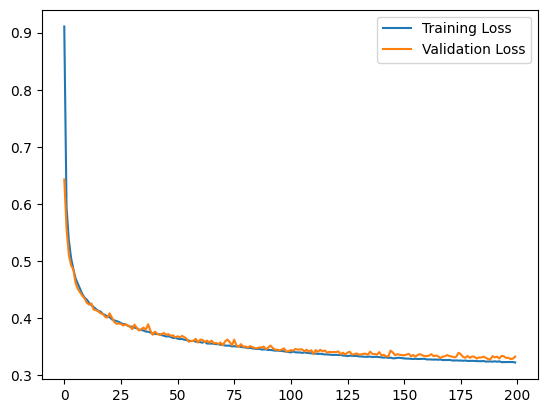

In [46]:
plt.plot(model.train_loss.data.cpu().numpy())
plt.plot(model.val_loss.data.cpu().numpy())
plt.legend(['Training Loss','Validation Loss'])

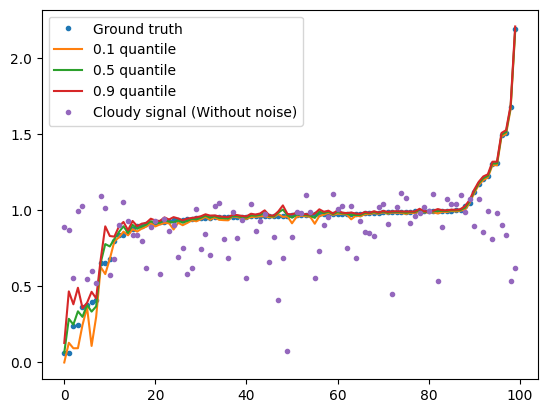

In [47]:
samples=100
channel=5

#Get ground truth y
y_plot=y_test.to_numpy()[:,channel]
y_plot=y_plot[0:samples]
sort_ind=np.argsort(y_plot)
y_plot_sort=y_plot[sort_ind]

#Get y predictions
y_pred=preds[:,channel,:]
y_pred=y_pred[0:samples,:]
y_pred_sort=y_pred[sort_ind,:]

# Get cloudy signal
cloudy=X_test_truth.to_numpy()[:,channel]
cloudy=cloudy[0:samples]
cloudy_sort=cloudy[sort_ind]


plt.plot(y_plot_sort,'.')
plt.plot(y_pred_sort)
plt.plot(cloudy_sort,'.')
plt.legend(['Ground truth','0.1 quantile', '0.5 quantile','0.9 quantile','Cloudy signal (Without noise)'])
plt.show()


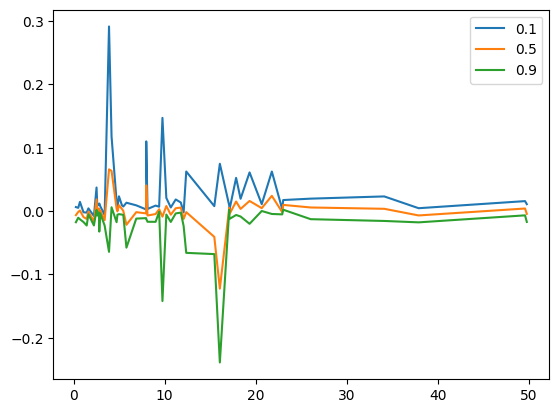

In [49]:
channel=5
samples=50

df_test=df.iloc[y_test.index]

#Get cot values
cot_column=df_test['COT'].to_numpy()
cot_column=cot_column[0:samples]
sort_ind=np.argsort(cot_column)
cot_column_sort=cot_column[sort_ind]

#Get ground truth
y_plot=y_test.to_numpy()[:,channel]
y_plot=y_plot[0:samples]
y_plot_sort=y_plot[sort_ind]

#Get y predictions
y_pred=preds[:,channel,:]
y_pred=y_pred[0:samples,:]
y_pred_sort=y_pred[sort_ind,:]

#Repeat ground truth to prepp difference
y_rep=np.repeat(y_plot_sort,len(quantiles),axis=0)
y_rep=np.reshape(y_rep,(-1,len(quantiles)))
diff=y_rep-y_pred_sort

#plt.plot(cot_column_sort,y_plot_sort,'.')
#plt.plot(cot_column_sort,y_pred_sort,'.')
plt.plot(cot_column_sort,diff)
plt.legend(['0.1','0.5','0.9'])

In [50]:
hf.save_model_and_test_data(filepath='pytorch_models/'+str(nepochs)+'epochs',model=model,X_test=X_test,y_test=y_test)

## Test multiple runs

In [ ]:
num_epochs=[10,20]

sequential_models=[ 
lambda: nn.Sequential(
    nn.Linear(len(X_labels),64),
    nn.ReLU(),
    nn.Linear(64,64),
    nn.ReLU(),
    nn.Linear(64, len(quantiles)*len(y_labels))
),
lambda: nn.Sequential(
    nn.Linear(len(X_labels),128),
    nn.ReLU(),
    nn.Linear(128,128),
    nn.ReLU(),
    nn.Linear(128, len(quantiles)*len(y_labels))
)]

In [ ]:
sequential_models[0]

<function __main__.<lambda>()>

In [ ]:
for nepochs in num_epochs:
    for i,sequantial in enumerate(sequential_models):
        
        model=QuantileNetwork(quantiles=quantiles)
        model.fit(X_train.to_numpy(),y_train.to_numpy(), 
          train_indices, 
          validation_indices, 
          batch_size=batch_size,
          nepochs=nepochs,
          sequence=sequantial())
        
        hf.save_model_and_test_data(filepath='pytorch_models/'+str(nepochs)+'epochs_'+'network_index_'+str(i),
                                    model=model,X_test=X_test,y_test=y_test)
        
                

Epoch 1


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 378.62it/s]


Training loss [0.83696735] Validation loss [0.63547623]
----New best validation loss---- [0.63547623]
Epoch 2


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 379.59it/s]


Training loss [0.5936159] Validation loss [0.5662661]
----New best validation loss---- [0.5662661]
Epoch 3


Batch number: 100%|██████████| 1805/1805 [00:04<00:00, 367.38it/s]

Training loss [0.54953486] Validation loss [0.53734994]
----New best validation loss---- [0.53734994]
Epoch 4



Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 334.23it/s]


Training loss [0.5261939] Validation loss [0.51872796]
----New best validation loss---- [0.51872796]
Epoch 5


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 336.82it/s]


Training loss [0.5097564] Validation loss [0.50228703]
----New best validation loss---- [0.50228703]
Epoch 6


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 335.73it/s]


Training loss [0.49633154] Validation loss [0.49053398]
----New best validation loss---- [0.49053398]
Epoch 7


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 330.14it/s]


Training loss [0.48624393] Validation loss [0.48696437]
----New best validation loss---- [0.48696437]
Epoch 8


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 343.10it/s]


Training loss [0.47754085] Validation loss [0.48830155]
Epoch 9


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 345.14it/s]


Training loss [0.47239843] Validation loss [0.4767115]
----New best validation loss---- [0.4767115]
Epoch 10


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 335.93it/s]


Training loss [0.46582168] Validation loss [0.47120282]
----New best validation loss---- [0.47120282]
Best model out of total max epochs found at epoch 10
Epoch 1


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 279.00it/s]


Training loss [0.74710727] Validation loss [0.59853846]
----New best validation loss---- [0.59853846]
Epoch 2


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 276.74it/s]


Training loss [0.5416226] Validation loss [0.51338124]
----New best validation loss---- [0.51338124]
Epoch 3


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 278.91it/s]


Training loss [0.5015558] Validation loss [0.49200144]
----New best validation loss---- [0.49200144]
Epoch 4


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 278.77it/s]


Training loss [0.47958708] Validation loss [0.46688986]
----New best validation loss---- [0.46688986]
Epoch 5


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 279.18it/s]


Training loss [0.46413198] Validation loss [0.46099007]
----New best validation loss---- [0.46099007]
Epoch 6


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 275.95it/s]


Training loss [0.4538667] Validation loss [0.44907513]
----New best validation loss---- [0.44907513]
Epoch 7


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 277.22it/s]


Training loss [0.44544902] Validation loss [0.43793103]
----New best validation loss---- [0.43793103]
Epoch 8


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 276.86it/s]


Training loss [0.43889317] Validation loss [0.43681064]
----New best validation loss---- [0.43681064]
Epoch 9


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 277.69it/s]


Training loss [0.43285266] Validation loss [0.43163306]
----New best validation loss---- [0.43163306]
Epoch 10


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 276.02it/s]


Training loss [0.42831337] Validation loss [0.4289991]
----New best validation loss---- [0.4289991]
Best model out of total max epochs found at epoch 10
Epoch 1


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 338.28it/s]


Training loss [0.8289272] Validation loss [0.6278596]
----New best validation loss---- [0.6278596]
Epoch 2


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 343.51it/s]


Training loss [0.59013146] Validation loss [0.5670168]
----New best validation loss---- [0.5670168]
Epoch 3


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 333.52it/s]

Training loss [0.54374343] Validation loss [0.52804935]
----New best validation loss---- [0.52804935]
Epoch 4



Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 335.86it/s]


Training loss [0.51911163] Validation loss [0.5064952]
----New best validation loss---- [0.5064952]
Epoch 5


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 333.59it/s]

Training loss [0.50237507] Validation loss [0.4985021]
----New best validation loss---- [0.4985021]
Epoch 6



Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 325.63it/s]


Training loss [0.4897616] Validation loss [0.48198858]
----New best validation loss---- [0.48198858]
Epoch 7


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 343.76it/s]


Training loss [0.47965378] Validation loss [0.4759047]
----New best validation loss---- [0.4759047]
Epoch 8


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 334.16it/s]


Training loss [0.4725613] Validation loss [0.4704416]
----New best validation loss---- [0.4704416]
Epoch 9


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 334.80it/s]


Training loss [0.4669337] Validation loss [0.4686748]
----New best validation loss---- [0.4686748]
Epoch 10


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 330.81it/s]


Training loss [0.46178782] Validation loss [0.46135437]
----New best validation loss---- [0.46135437]
Epoch 11


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 332.70it/s]

Training loss [0.45694506] Validation loss [0.46262273]
Epoch 12



Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 342.91it/s]


Training loss [0.45339295] Validation loss [0.4603163]
----New best validation loss---- [0.4603163]
Epoch 13


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 333.14it/s]

Training loss [0.45014533] Validation loss [0.45136273]
----New best validation loss---- [0.45136273]
Epoch 14



Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 332.00it/s]


Training loss [0.44666174] Validation loss [0.44615167]
----New best validation loss---- [0.44615167]
Epoch 15


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 336.28it/s]


Training loss [0.44378883] Validation loss [0.45222077]
Epoch 16


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 335.28it/s]


Training loss [0.4417707] Validation loss [0.4412019]
----New best validation loss---- [0.4412019]
Epoch 17


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 344.93it/s]


Training loss [0.43858215] Validation loss [0.44448686]
Epoch 18


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 332.70it/s]


Training loss [0.43712544] Validation loss [0.43949503]
----New best validation loss---- [0.43949503]
Epoch 19


Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 333.32it/s]

Training loss [0.43471697] Validation loss [0.43649763]
----New best validation loss---- [0.43649763]
Epoch 20



Batch number: 100%|██████████| 1805/1805 [00:05<00:00, 333.94it/s]


Training loss [0.43274269] Validation loss [0.43574896]
----New best validation loss---- [0.43574896]
Best model out of total max epochs found at epoch 20
Epoch 1


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 258.81it/s]


Training loss [0.75236434] Validation loss [0.578092]
----New best validation loss---- [0.578092]
Epoch 2


Batch number: 100%|██████████| 1805/1805 [00:07<00:00, 253.53it/s]


Training loss [0.54224783] Validation loss [0.51310426]
----New best validation loss---- [0.51310426]
Epoch 3


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 266.91it/s]


Training loss [0.49883968] Validation loss [0.4763381]
----New best validation loss---- [0.4763381]
Epoch 4


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 258.40it/s]


Training loss [0.4747396] Validation loss [0.4631469]
----New best validation loss---- [0.4631469]
Epoch 5


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 268.32it/s]


Training loss [0.45809036] Validation loss [0.456204]
----New best validation loss---- [0.456204]
Epoch 6


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 267.29it/s]


Training loss [0.44690385] Validation loss [0.44528773]
----New best validation loss---- [0.44528773]
Epoch 7


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 268.96it/s]


Training loss [0.43831152] Validation loss [0.4353292]
----New best validation loss---- [0.4353292]
Epoch 8


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 273.17it/s]

Training loss [0.43105376] Validation loss [0.42888376]


----New best validation loss---- [0.42888376]
Epoch 9


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 273.79it/s]


Training loss [0.42516756] Validation loss [0.41713938]
----New best validation loss---- [0.41713938]
Epoch 10


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 266.25it/s]


Training loss [0.41991258] Validation loss [0.42020005]
Epoch 11


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 269.22it/s]


Training loss [0.41629064] Validation loss [0.41809872]
Epoch 12


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 267.61it/s]


Training loss [0.41278514] Validation loss [0.4086831]
----New best validation loss---- [0.4086831]
Epoch 13


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 274.40it/s]


Training loss [0.4090438] Validation loss [0.40915322]
Epoch 14


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 271.58it/s]


Training loss [0.4074085] Validation loss [0.40762222]
----New best validation loss---- [0.40762222]
Epoch 15


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 275.62it/s]


Training loss [0.40382543] Validation loss [0.41051802]
Epoch 16


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 273.59it/s]


Training loss [0.4019043] Validation loss [0.4081948]
Epoch 17


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 271.45it/s]


Training loss [0.3994392] Validation loss [0.4008681]
----New best validation loss---- [0.4008681]
Epoch 18


Batch number: 100%|██████████| 1805/1805 [00:07<00:00, 255.08it/s]


Training loss [0.39684406] Validation loss [0.40343854]
Epoch 19


Batch number: 100%|██████████| 1805/1805 [00:06<00:00, 266.26it/s]


Training loss [0.39476365] Validation loss [0.3988069]
----New best validation loss---- [0.3988069]
Epoch 20


Batch number:   1%|▏         | 27/1805 [00:00<00:06, 267.24it/s]

## Testloading a model

In [ ]:
model, X_test, y_test = hf.load_model_and_test_data(filepath='pytorch_models/10epochs_network_index_0')